In [1]:
import numpy as np
import matplotlib.pyplot as plt
from docplex.mp.model import Model

from qiskit_aer import Aer,AerSimulator
from qiskit_algorithms import QAOA, NumPyMinimumEigensolver
from qiskit_optimization.algorithms import CplexOptimizer, MinimumEigenOptimizer
from qiskit_optimization.algorithms.admm_optimizer import ADMMParameters, ADMMOptimizer
from qiskit_optimization import QuadraticProgram

from qiskit_optimization.converters import InequalityToEquality, IntegerToBinary, LinearEqualityToPenalty

# 1.problem statement
# 
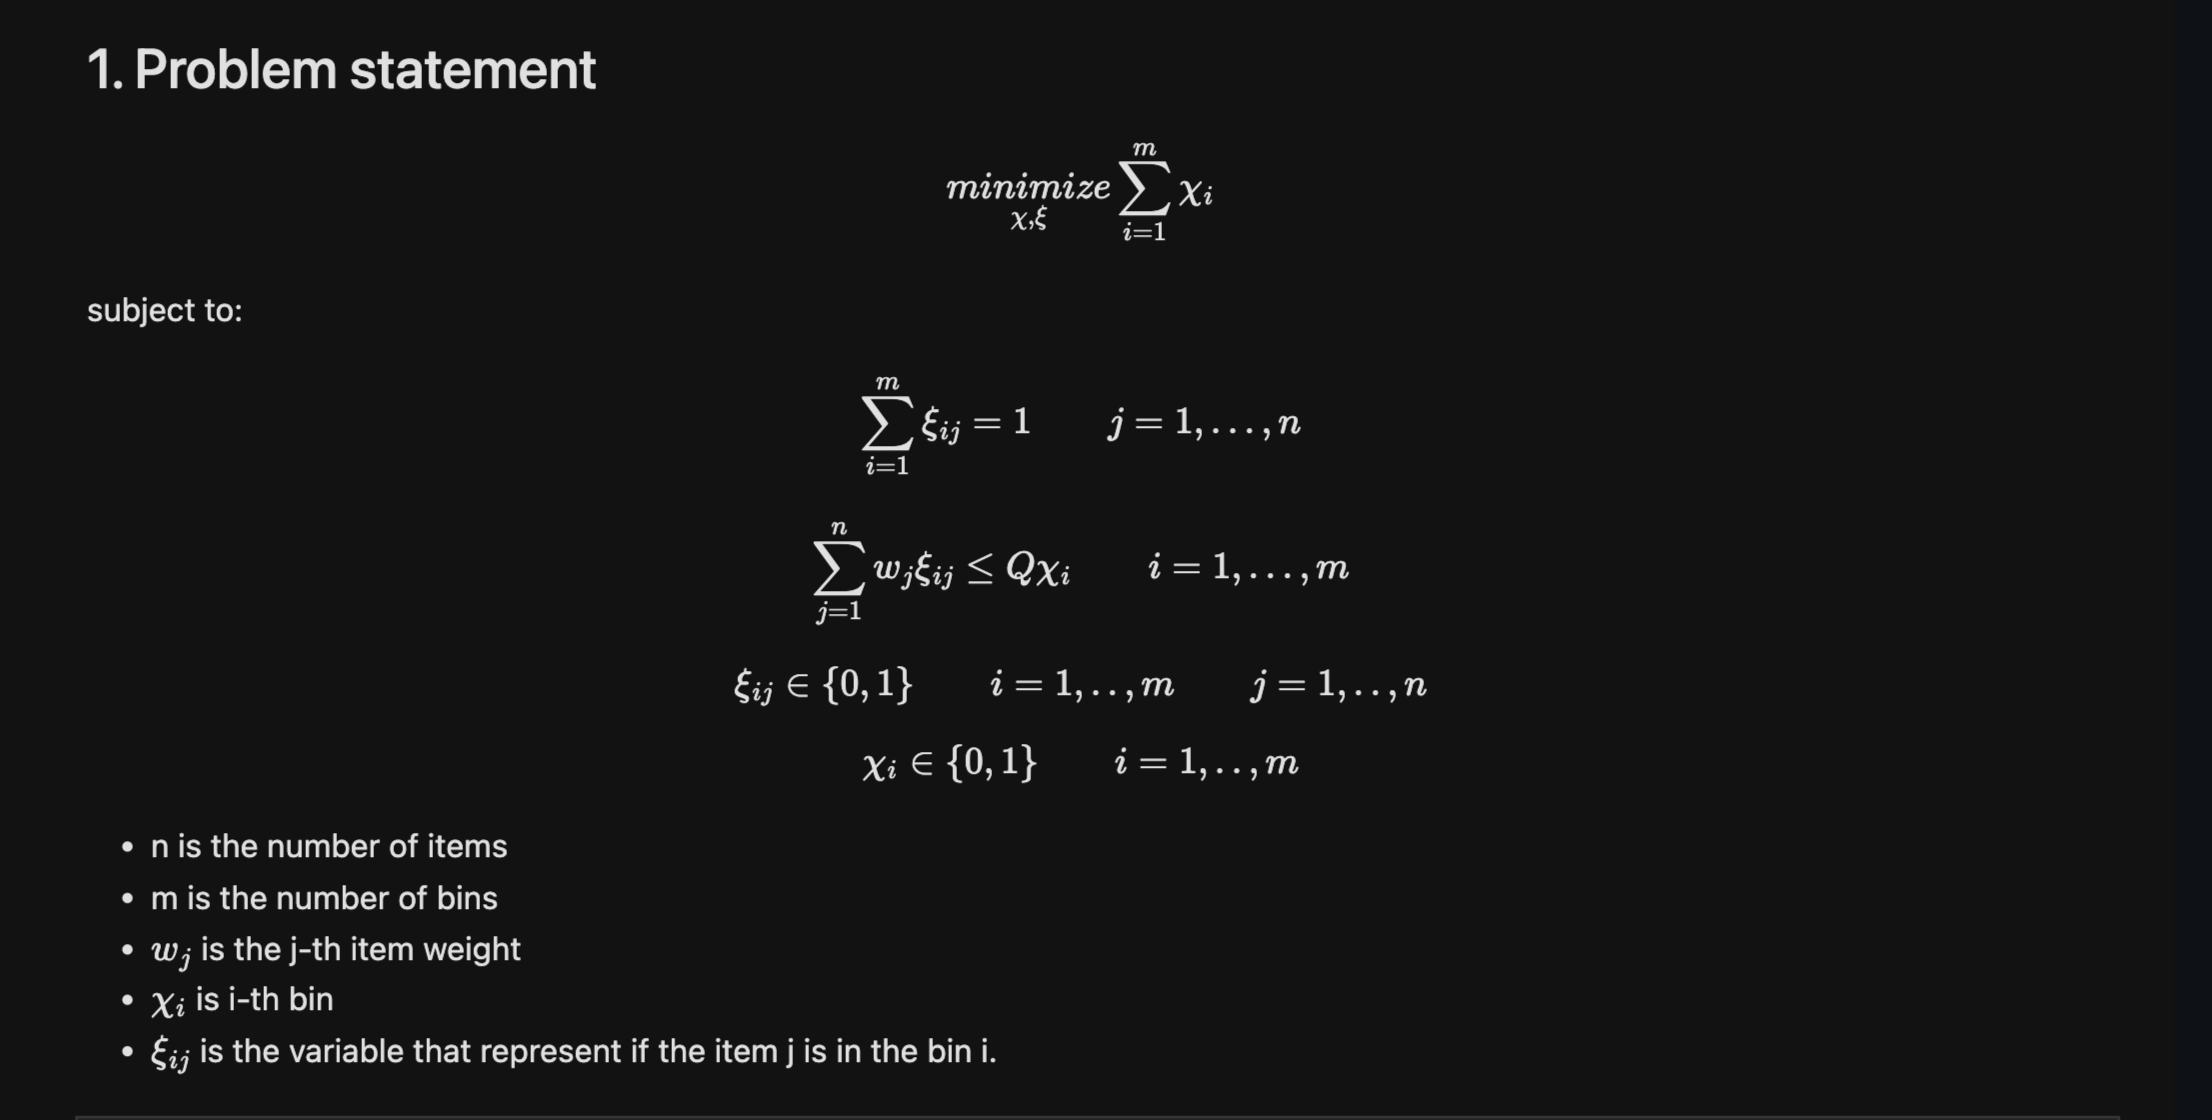

In [2]:
!pip install docplex
!pip install qiskit-algorithms
!pip install qiskit-optimization


[notice] A new release of pip is available: 24.1.2 -> 24.2
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip is available: 24.1.2 -> 24.2
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip is available: 24.1.2 -> 24.2
[notice] To update, run: pip install --upgrade pip


# defining the data bins


In [3]:
def data_bins(results, wj, n, m, l=0, simplify=False):
    """save the results on a dictionary with the three items, bins, items, and index.
    results (cplex.solve): results of the optimization
    wj: (array (1,m): weights of the items
    n: (int) number of items
    m: (int) number of bins
    """
    if simplify:
        bins = np.ones((m,))
        if m-l > 0: 
            bins[m-l-1:m] = results[:m-l]
        items = np.zeros((m,n))
        items[:,1:] =  results[m-l:(m-1)*n+m-l].reshape(m,n-1)
        items[0,0] = 1
        items = items.reshape(m,n) * wj
        return {"bins":bins, "items":items,"index":np.arange(m)}
    else:        
        return {"bins":results[:m], "items":results[m:m+m*n].reshape(m,n) * wj, "index":np.arange(m)}
def plot_bins(results, wj, n, m, l=0,simplify=False):
    """plot in a bar diagram the results of an optimization bin packing problem"""
    res = data_bins(results.x, wj, n, m, l, simplify)
    plt.figure()
    ind = res["index"]
    plt.bar(ind, res["items"][:,0], label=f"item {0}")
    suma = bottom=res["items"][:,0]
    for j in range(1,n):
        plt.bar(ind, res["items"][:,j], bottom=suma, label=f"item {j}")
        suma += res["items"][:,j]
    plt.hlines(Q,0-0.5,m-0.5,linestyle="--", color="r",label="Max W")
    plt.xticks(ind)
    plt.xlabel("Bin")
    plt.ylabel("Weight")
    plt.legend()

In [4]:
np.random.seed(2)
n = 3 # number of bins
m = n # number of items
Q = 40 # max weight of a bin
import numpy as np

wj = np.random.randint(1,Q,n) # Randomly picking the item weight

 # constructing the docplex model for our objective function

In [5]:
# Construct model using docplex
from qiskit_optimization import QuadraticProgram
from qiskit_optimization import QuadraticProgram
from qiskit_optimization.translators.docplex_mp import to_docplex_mp
from qiskit_optimization.translators import from_docplex_mp
from docplex.mp.model import Model
mdl = Model("BinPacking")

x = mdl.binary_var_list([f"x{i}" for i in range(n)]) # list of variables that represent the bins
e =  mdl.binary_var_list([f"e{i//m},{i%m}" for i in range(n*m)]) # variables that represent the items on the specific bin

objective = mdl.sum([x[i] for i in range(n)])

mdl.minimize(objective)


for j in range(m):
    # First set of constraints: the items must be in any bin
    constraint0 = mdl.sum([e[i*m+j] for i in range(n)])
    mdl.add_constraint(constraint0 == 1, f"cons0,{j}")
    
for i in range(n):
    # Second set of constraints: weight constraints
    constraint1 = mdl.sum([wj[j] * e[i*m+j] for j in range(m)])
    mdl.add_constraint(constraint1 <= Q * x[i], f"cons1,{i}")


# Load quadratic program from docplex model
qp = QuadraticProgram()
qp=from_docplex_mp(mdl)

# Extract the Ising Hamiltonian and variable mappings
print(mdl.export_as_lp_string())




\ This file has been generated by DOcplex
\ ENCODING=ISO-8859-1
\Problem name: BinPacking

Minimize
 obj: x0 + x1 + x2
Subject To
 cons0,0: _e0,0 + _e1,0 + _e2,0 = 1
 cons0,1: _e0,1 + _e1,1 + _e2,1 = 1
 cons0,2: _e0,2 + _e1,2 + _e2,2 = 1
 cons1,0: 16 _e0,0 + 9 _e0,1 + 23 _e0,2 - 40 x0 <= 0
 cons1,1: 16 _e1,0 + 9 _e1,1 + 23 _e1,2 - 40 x1 <= 0
 cons1,2: 16 _e2,0 + 9 _e2,1 + 23 _e2,2 - 40 x2 <= 0

Bounds
 0 <= x0 <= 1
 0 <= x1 <= 1
 0 <= x2 <= 1
 0 <= _e0,0 <= 1
 0 <= _e0,1 <= 1
 0 <= _e0,2 <= 1
 0 <= _e1,0 <= 1
 0 <= _e1,1 <= 1
 0 <= _e1,2 <= 1
 0 <= _e2,0 <= 1
 0 <= _e2,1 <= 1
 0 <= _e2,2 <= 1

Binaries
 x0 x1 x2 _e0,0 _e0,1 _e0,2 _e1,0 _e1,1 _e1,2 _e2,0 _e2,1 _e2,2
End



fval=2.0, x0=1.0, x1=0.0, x2=1.0, e0,0=1.0, e0,1=1.0, e0,2=0.0, e1,0=0.0, e1,1=0.0, e1,2=0.0, e2,0=0.0, e2,1=0.0, e2,2=1.0, status=SUCCESS


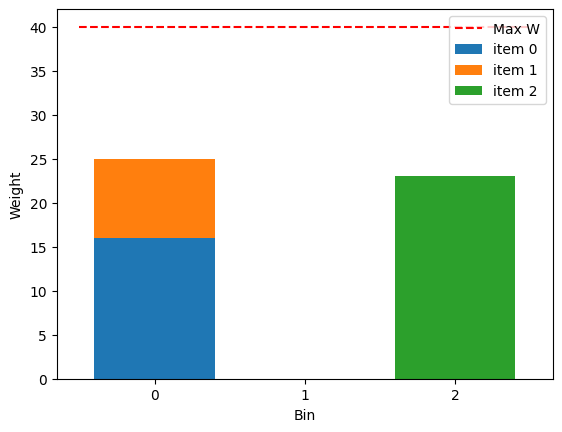

In [6]:
# convert from DOcplex model to Qiskit Quadratic program
qp = QuadraticProgram()
qp=from_docplex_mp(mdl)

# Solving Quadratic Program using CPLEX
cplex = CplexOptimizer()
result = cplex.solve(qp)
print(result)
plot_bins(result, wj, n, m)

In [7]:
!pip install 'qiskit-optimization[cplex]'


[notice] A new release of pip is available: 24.1.2 -> 24.2
[notice] To update, run: pip install --upgrade pip


In [8]:
from qiskit_optimization import QuadraticProgram
from qiskit_optimization.translators import from_docplex_mp
from docplex.mp.model import Model


In [9]:
# Construct model using docplex
mdl = Model("BinPacking_simplify")

l = int(np.ceil(np.sum(wj)/Q))
x = mdl.binary_var_list([f"x{i}" for i in range(m)]) # list of variables that represent the bins
e =  mdl.binary_var_list([f"e{i//m},{i%m}" for i in range(n*m)]) # variables that represent the items on the specific bin

objective = mdl.sum([x[i] for i in range(n)])

mdl.minimize(objective)

for j in range(m):
    # First set of constraints: the items must be in any bin
    constraint0 = mdl.sum([e[i*m+j] for i in range(n)])
    mdl.add_constraint(constraint0 == 1, f"cons0,{j}")
    
for i in range(n):
    # Second set of constraints: weight constraints
    constraint1 = mdl.sum([wj[j] * e[i*m+j] for j in range(m)])
    mdl.add_constraint(constraint1 <= Q * x[i], f"cons1,{i}")


# Load quadratic program from docplex model
qp = QuadraticProgram()
qp=from_docplex_mp(mdl)
# Simplifying the problem
for i in range(l):
    qp = qp.substitute_variables({f"x{i}":1}) 
qp = qp.substitute_variables({"e0,0":1}) 
for i in range(1,m):
    qp = qp.substitute_variables({f"e{i},0":0})
print(qp.prettyprint())
print(mdl.export_as_lp_string())


Problem name: BinPacking_simplify

Minimize
  x2 + 2

Subject to
  Linear constraints (5)
    e0,1 + e1,1 + e2,1 == 1  'cons0,1'
    e0,2 + e1,2 + e2,2 == 1  'cons0,2'
    9*e0,1 + 23*e0,2 <= 24  'cons1,0'
    9*e1,1 + 23*e1,2 <= 40  'cons1,1'
    9*e2,1 + 23*e2,2 - 40*x2 <= 0  'cons1,2'

  Binary variables (7)
    x2 e0,1 e0,2 e1,1 e1,2 e2,1 e2,2

\ This file has been generated by DOcplex
\ ENCODING=ISO-8859-1
\Problem name: BinPacking_simplify

Minimize
 obj: x0 + x1 + x2
Subject To
 cons0,0: _e0,0 + _e1,0 + _e2,0 = 1
 cons0,1: _e0,1 + _e1,1 + _e2,1 = 1
 cons0,2: _e0,2 + _e1,2 + _e2,2 = 1
 cons1,0: 16 _e0,0 + 9 _e0,1 + 23 _e0,2 - 40 x0 <= 0
 cons1,1: 16 _e1,0 + 9 _e1,1 + 23 _e1,2 - 40 x1 <= 0
 cons1,2: 16 _e2,0 + 9 _e2,1 + 23 _e2,2 - 40 x2 <= 0

Bounds
 0 <= x0 <= 1
 0 <= x1 <= 1
 0 <= x2 <= 1
 0 <= _e0,0 <= 1
 0 <= _e0,1 <= 1
 0 <= _e0,2 <= 1
 0 <= _e1,0 <= 1
 0 <= _e1,1 <= 1
 0 <= _e1,2 <= 1
 0 <= _e2,0 <= 1
 0 <= _e2,1 <= 1
 0 <= _e2,2 <= 1

Binaries
 x0 x1 x2 _e0,0 _e0,1 _e0,2 _e

# solving the quadratic programming using CPLEX

fval=2.0, x2=0.0, e0,1=0.0, e0,2=0.0, e1,1=1.0, e1,2=1.0, e2,1=0.0, e2,2=0.0, status=SUCCESS


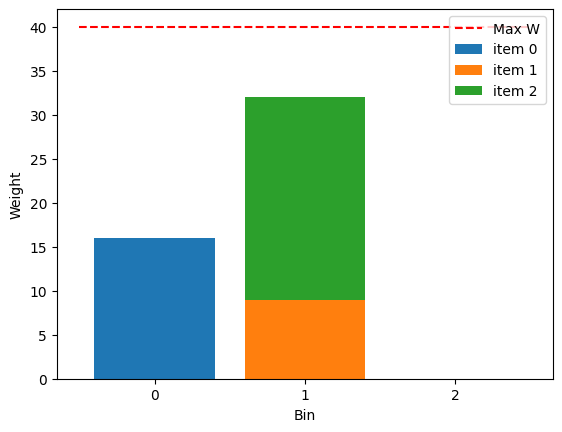

In [10]:

simplify_result = cplex.solve(qp)
print(simplify_result)
plot_bins(simplify_result, wj, n, m, l, simplify=True)

# defining the  function for optimal solution 

In [32]:
print("Optimal Solution:")
for i, var in enumerate(qubo.variables):
    print(f"{var.name}: {result_qaoa.x[i]}")

# Print the optimal objective function value (minimum value)
print(f"Optimal Objective Function Value: {result_qaoa.fval}")

Optimal Solution:
x2: 1.0
e0,1: 1.0
e0,2: 0.0
e1,1: 1.0
e1,2: 0.0
e2,1: 0.0
e2,2: 1.0
cons1,0@int_slack@0: 0.0
cons1,0@int_slack@1: 1.0
cons1,0@int_slack@2: 1.0
cons1,0@int_slack@3: 1.0
cons1,0@int_slack@4: 0.0
cons1,1@int_slack@0: 0.0
cons1,1@int_slack@1: 1.0
cons1,1@int_slack@2: 1.0
cons1,1@int_slack@3: 1.0
cons1,1@int_slack@4: 1.0
cons1,1@int_slack@5: 0.0
cons1,2@int_slack@0: 1.0
cons1,2@int_slack@1: 0.0
cons1,2@int_slack@2: 0.0
cons1,2@int_slack@3: 1.0
cons1,2@int_slack@4: 0.0
cons1,2@int_slack@5: 1.0
Optimal Objective Function Value: 11.0


# cnonverting it from inequality constraints into equality constraints

In [11]:
ineq2eq = InequalityToEquality()
qp_eq = ineq2eq.convert(qp)
print(qp_eq.export_as_lp_string())
print(f"The number of variables is {qp_eq.get_num_vars()}")

\ This file has been generated by DOcplex
\ ENCODING=ISO-8859-1
\Problem name: BinPacking_simplify

Minimize
 obj: x2 + 2
Subject To
 cons0,1: _e0,1 + _e1,1 + _e2,1 = 1
 cons0,2: _e0,2 + _e1,2 + _e2,2 = 1
 cons1,0: 9 _e0,1 + 23 _e0,2 + cons1,0@int_slack = 24
 cons1,1: 9 _e1,1 + 23 _e1,2 + cons1,1@int_slack = 40
 cons1,2: - 40 x2 + 9 _e2,1 + 23 _e2,2 + cons1,2@int_slack = 0

Bounds
 0 <= x2 <= 1
 0 <= _e0,1 <= 1
 0 <= _e0,2 <= 1
 0 <= _e1,1 <= 1
 0 <= _e1,2 <= 1
 0 <= _e2,1 <= 1
 0 <= _e2,2 <= 1
       cons1,0@int_slack <= 24
       cons1,1@int_slack <= 40
       cons1,2@int_slack <= 40

Binaries
 x2 _e0,1 _e0,2 _e1,1 _e1,2 _e2,1 _e2,2

Generals
 cons1,0@int_slack cons1,1@int_slack cons1,2@int_slack
End

The number of variables is 10


# converting from integer constrained probel to binary constrained problem

In [12]:
int2bin = IntegerToBinary()
qp_eq_bin = int2bin.convert(qp_eq)
print(qp_eq_bin.export_as_lp_string())
print(f"The number of variables is {qp_eq_bin.get_num_vars()}")

\ This file has been generated by DOcplex
\ ENCODING=ISO-8859-1
\Problem name: BinPacking_simplify

Minimize
 obj: x2 + 2
Subject To
 cons0,1: _e0,1 + _e1,1 + _e2,1 = 1
 cons0,2: _e0,2 + _e1,2 + _e2,2 = 1
 cons1,0: 9 _e0,1 + 23 _e0,2 + cons1,0@int_slack@0 + 2 cons1,0@int_slack@1
          + 4 cons1,0@int_slack@2 + 8 cons1,0@int_slack@3
          + 9 cons1,0@int_slack@4 = 24
 cons1,1: 9 _e1,1 + 23 _e1,2 + cons1,1@int_slack@0 + 2 cons1,1@int_slack@1
          + 4 cons1,1@int_slack@2 + 8 cons1,1@int_slack@3
          + 16 cons1,1@int_slack@4 + 9 cons1,1@int_slack@5 = 40
 cons1,2: - 40 x2 + 9 _e2,1 + 23 _e2,2 + cons1,2@int_slack@0
          + 2 cons1,2@int_slack@1 + 4 cons1,2@int_slack@2
          + 8 cons1,2@int_slack@3 + 16 cons1,2@int_slack@4
          + 9 cons1,2@int_slack@5 = 0

Bounds
 0 <= x2 <= 1
 0 <= _e0,1 <= 1
 0 <= _e0,2 <= 1
 0 <= _e1,1 <= 1
 0 <= _e1,2 <= 1
 0 <= _e2,1 <= 1
 0 <= _e2,2 <= 1
 0 <= cons1,0@int_slack@0 <= 1
 0 <= cons1,0@int_slack@1 <= 1
 0 <= cons1,0@int_slack@

# converting the linear equality constraints into penalties

In [13]:
lineq2penalty = LinearEqualityToPenalty()
qubo = lineq2penalty.convert(qp_eq_bin)
print(f"The number of variables is {qp_eq_bin.get_num_vars()}")
print(qubo.export_as_lp_string())

The number of variables is 24
\ This file has been generated by DOcplex
\ ENCODING=ISO-8859-1
\Problem name: BinPacking_simplify

Minimize
 obj: x2 - 868 _e0,1 - 2212 _e0,2 - 1444 _e1,1 - 3684 _e1,2 - 4 _e2,1 - 4 _e2,2
      - 96 cons1,0@int_slack@0 - 192 cons1,0@int_slack@1
      - 384 cons1,0@int_slack@2 - 768 cons1,0@int_slack@3
      - 864 cons1,0@int_slack@4 - 160 cons1,1@int_slack@0
      - 320 cons1,1@int_slack@1 - 640 cons1,1@int_slack@2
      - 1280 cons1,1@int_slack@3 - 2560 cons1,1@int_slack@4
      - 1440 cons1,1@int_slack@5 + [ 6400 x2^2 - 2880 x2*_e2,1 - 7360 x2*_e2,2
      - 320 x2*cons1,2@int_slack@0 - 640 x2*cons1,2@int_slack@1
      - 1280 x2*cons1,2@int_slack@2 - 2560 x2*cons1,2@int_slack@3
      - 5120 x2*cons1,2@int_slack@4 - 2880 x2*cons1,2@int_slack@5 + 328 _e0,1^2
      + 1656 _e0,1*_e0,2 + 8 _e0,1*_e1,1 + 8 _e0,1*_e2,1
      + 72 _e0,1*cons1,0@int_slack@0 + 144 _e0,1*cons1,0@int_slack@1
      + 288 _e0,1*cons1,0@int_slack@2 + 576 _e0,1*cons1,0@int_slack@3
     

# solving the QUBO(Quadratic uncontrained binary optimization problem ) using CPLEX

In [14]:
result = cplex.solve(qubo)
print(result)

fval=2.0, x2=0.0, e0,1=0.0, e0,2=1.0, e1,1=1.0, e1,2=0.0, e2,1=0.0, e2,2=0.0, cons1,0@int_slack@0=1.0, cons1,0@int_slack@1=0.0, cons1,0@int_slack@2=0.0, cons1,0@int_slack@3=0.0, cons1,0@int_slack@4=0.0, cons1,1@int_slack@0=1.0, cons1,1@int_slack@1=1.0, cons1,1@int_slack@2=1.0, cons1,1@int_slack@3=1.0, cons1,1@int_slack@4=1.0, cons1,1@int_slack@5=0.0, cons1,2@int_slack@0=0.0, cons1,2@int_slack@1=0.0, cons1,2@int_slack@2=0.0, cons1,2@int_slack@3=0.0, cons1,2@int_slack@4=0.0, cons1,2@int_slack@5=0.0, status=SUCCESS


# performing data analysis and visualization from the optimization results

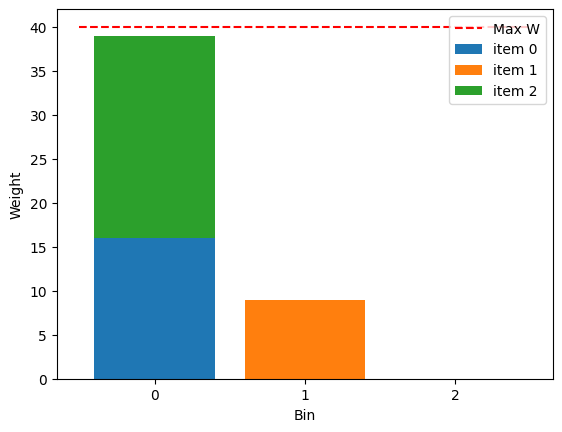

In [15]:
data_bins(result.x, wj, n, m, l=l, simplify=True)
plot_bins(result, wj, n, m, l=l, simplify=True)

# solving the optimization using backend

In [16]:
from qiskit_aer import AerSimulator
from qiskit_ibm_runtime.fake_provider import FakeAlmadenV2
backend = FakeAlmadenV2()

from qiskit_algorithms.minimum_eigensolvers import QAOA
from qiskit_algorithms.optimizers import COBYLA
from qiskit.quantum_info import SparsePauliOp
from qiskit.primitives import Sampler
from qiskit_aer.primitives import Sampler as AerSampler
from qiskit_optimization.algorithms import MinimumEigenOptimizer

sampler = Sampler()
sampler = AerSampler(backend_options={"method": "statevector"},
                     run_options={"shots": 1024, "seed": 42})

 
optimizer=COBYLA(maxiter=100)

# using QAOA to solve the QUBO problem

In [17]:
qaoa = MinimumEigenOptimizer(QAOA(sampler, optimizer, reps = 1))
result_qaoa = qaoa.solve(qubo)
print(result_qaoa)

fval=11.0, x2=1.0, e0,1=1.0, e0,2=0.0, e1,1=1.0, e1,2=0.0, e2,1=0.0, e2,2=1.0, cons1,0@int_slack@0=0.0, cons1,0@int_slack@1=1.0, cons1,0@int_slack@2=1.0, cons1,0@int_slack@3=1.0, cons1,0@int_slack@4=0.0, cons1,1@int_slack@0=0.0, cons1,1@int_slack@1=1.0, cons1,1@int_slack@2=1.0, cons1,1@int_slack@3=1.0, cons1,1@int_slack@4=1.0, cons1,1@int_slack@5=0.0, cons1,2@int_slack@0=1.0, cons1,2@int_slack@1=0.0, cons1,2@int_slack@2=0.0, cons1,2@int_slack@3=1.0, cons1,2@int_slack@4=0.0, cons1,2@int_slack@5=1.0, status=SUCCESS


Text(0.5, 1.0, 'QAOA solution')

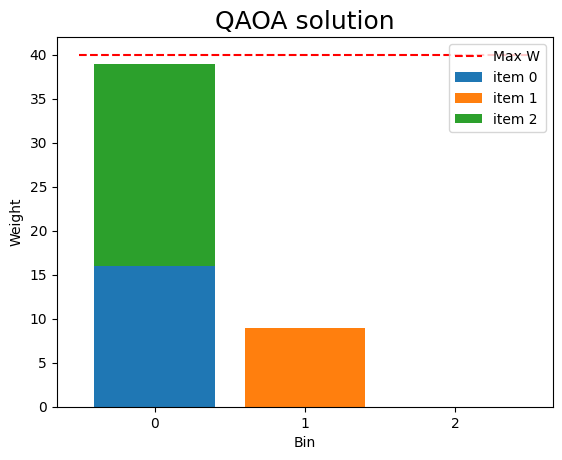

In [18]:
plot_bins(result, wj, n, m, l, simplify=True)
plt.title("QAOA solution", fontsize=18)

# qudratic penalty function ( USP)

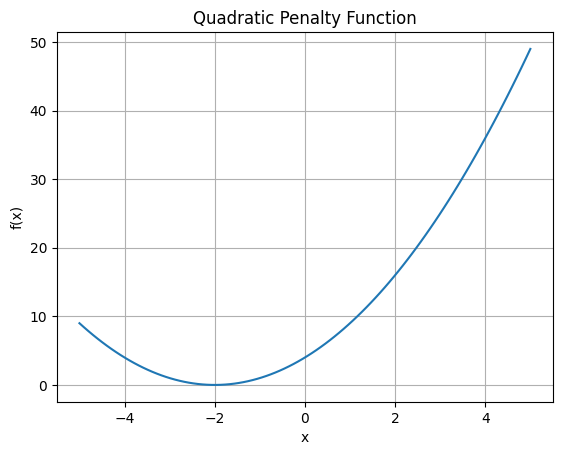

In [20]:
import numpy as np
import matplotlib.pyplot as plt

# Parameters
alpha = -2

# Generate x values
x = np.linspace(-5, 5, 100)

# Quadratic penalty function
f = (x - alpha)**2

# Plot the function
plt.figure()
plt.plot(x, f)
plt.grid()
plt.xlabel("x")
plt.ylabel("f(x)")
plt.title("Quadratic Penalty Function")
plt.show()


# constructing a model using the docplex method

In [71]:
from docplex.mp.model import Model
from qiskit_optimization import QuadraticProgram

# Define the model
mdl = Model("binPackingSoftPenalty")

# Number of bins (m) and items (n) assumed to be defined
# List of binary variables representing whether a bin is used (1 if used, 0 otherwise)
x = mdl.binary_var_list([f"x{i}" for i in range(m)])  

# List of binary variables representing whether item j is in bin i
e = mdl.binary_var_list([f"e{i//m},{i%n}" for i in range(n*m)])

# Objective function: minimize the number of bins used (sum of x[i])
objective = mdl.sum([x[i] for i in range(m)])

# Penalty term initialization for quadratic penalties
penalty = 0
alpha = 10  # Alpha can be adjusted to control the strength of the penalty

# Loop through bins to impose quadratic penalties for exceeding bin capacities
for i in range(m):
    # Expression for bin capacity constraint
    cons_1 = 0
    cons_1 += Q * x[i]  # Capacity of bin i
    for j in range(n):
        cons_1 -= wj[j] * e[i * m + j]  # Subtract weight of item j if placed in bin i
    
    # Soft quadratic penalty for bin capacity violation
    penalty += (cons_1 - alpha) ** 2  # Quadratic penalty if capacity exceeded

# Combine objective function with penalties
mdl.minimize(objective + penalty)

# Add constraints to ensure every item is assigned to exactly one bin
for j in range(n):
    constraint0 = mdl.sum([e[i * m + j] for i in range(m)])  # Sum over all bins for item j
    mdl.add_constraint(constraint0 == 1, f"cons0,{j}")

# Load quadratic program from docplex model
qp = QuadraticProgram()
qp=from_docplex_mp(mdl)

# Simplify the problem by substituting some variables (if required)
for i in range(l):
    qp = qp.substitute_variables({f"x{i}": 1})  # Example substitution for variables
qp = qp.substitute_variables({"e0,0": 1})  # Example substitution
for i in range(1, m):
    qp = qp.substitute_variables({f"e{i},0": 0})

# Output the final quadratic program
print(qp.export_as_lp_string())
print(f"The number of variables is {qp.get_num_vars()}")


\ This file has been generated by DOcplex
\ ENCODING=ISO-8859-1
\Problem name: binPackingSoftPenalty

Minimize
 obj: - 799 x2 - 252 _e0,1 - 644 _e0,2 - 540 _e1,1 - 1380 _e1,2 + 180 _e2,1
      + 460 _e2,2 + [ 3200 x2^2 - 1440 x2*_e2,1 - 3680 x2*_e2,2 + 162 _e0,1^2
      + 828 _e0,1*_e0,2 + 1058 _e0,2^2 + 162 _e1,1^2 + 828 _e1,1*_e1,2
      + 1058 _e1,2^2 + 162 _e2,1^2 + 828 _e2,1*_e2,2 + 1058 _e2,2^2 ]/2 + 1198
Subject To
 cons0,1: _e0,1 + _e1,1 + _e2,1 = 1
 cons0,2: _e0,2 + _e1,2 + _e2,2 = 1

Bounds
 0 <= x2 <= 1
 0 <= _e0,1 <= 1
 0 <= _e0,2 <= 1
 0 <= _e1,1 <= 1
 0 <= _e1,2 <= 1
 0 <= _e2,1 <= 1
 0 <= _e2,2 <= 1

Binaries
 x2 _e0,1 _e0,2 _e1,1 _e1,2 _e2,1 _e2,2
End

The number of variables is 7


#  Solving Quadratic Program using CPLEX

fval=176.0, x2=0.0, e0,1=1.0, e0,2=0.0, e1,1=0.0, e1,2=1.0, e2,1=0.0, e2,2=0.0, status=SUCCESS


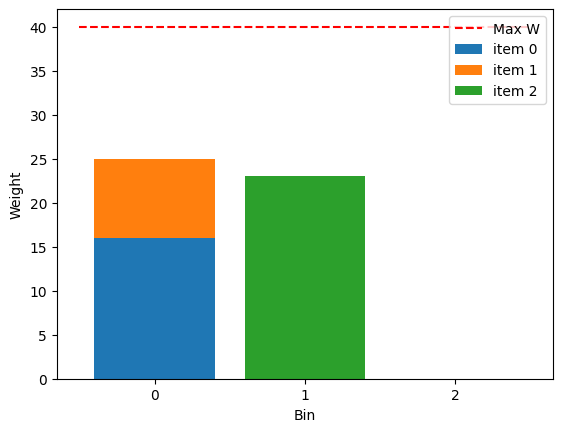

In [72]:
# Solving Quadratic Program using CPLEX
cplex = CplexOptimizer()
result = cplex.solve(qp)
print(result)
plot_bins(result, wj, n, m, l, simplify=True)

fval=176.0, x2=0.0, e0,1=1.0, e0,2=0.0, e1,1=0.0, e1,2=1.0, e2,1=0.0, e2,2=0.0, status=SUCCESS


Text(0.5, 1.0, 'QAOA solution')

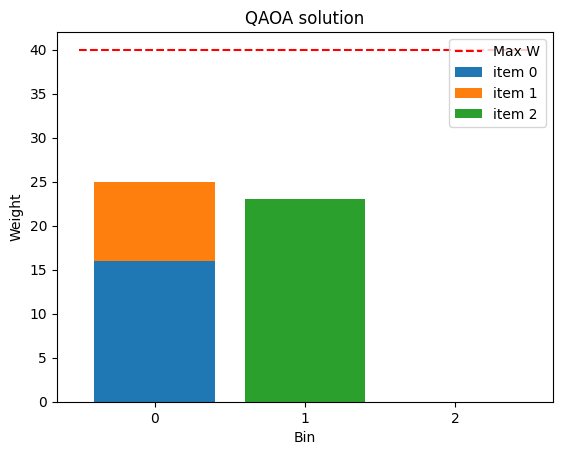

In [73]:
qubo_myapp = lineq2penalty.convert(qp)
result_myapp = qaoa.solve(qubo_myapp)
print(result_myapp)

plot_bins(result_myapp, wj, n, m, l, simplify=True)
plt.title("QAOA solution")

# function for optimizing the function value

In [74]:
# Solve the QUBO problem using QAOA
result_myapp = qaoa.solve(qubo_myapp)


# Print the result of the QAOA solution
print("QAOA Result:")
print(result_myapp)

# Print the optimal objective function value
print(f"Optimal Objective Function Value: {result_myapp.fval}")

QAOA Result:
fval=176.0, x2=0.0, e0,1=1.0, e0,2=0.0, e1,1=0.0, e1,2=1.0, e2,1=0.0, e2,2=0.0, status=SUCCESS
Optimal Objective Function Value: 176.0


# showcasing the difference between exponential and qudratic penalty approach

In [75]:
from docplex.mp.model import Model
from qiskit_optimization import QuadraticProgram

# Define the model
mdl = Model("binPackingSoftPenalty")

# Number of bins (m) and items (n) assumed to be defined
# List of binary variables representing whether a bin is used (1 if used, 0 otherwise)
x = mdl.binary_var_list([f"x{i}" for i in range(m)])  

# List of binary variables representing whether item j is in bin i
e = mdl.binary_var_list([f"e{i//m},{i%n}" for i in range(n*m)])

# Objective function: minimize the number of bins used (sum of x[i])
objective = mdl.sum([x[i] for i in range(m)])

# Penalty term initialization for quadratic penalties
penalty = 0
alpha = 10  # Alpha can be adjusted to control the strength of the penalty

# Loop through bins to impose quadratic penalties for exceeding bin capacities
for i in range(m):
    # Expression for bin capacity constraint
    cons_1 = 0
    cons_1 += Q * x[i]  # Capacity of bin i
    for j in range(n):
        cons_1 -= wj[j] * e[i * m + j]  # Subtract weight of item j if placed in bin i
    
    # Soft quadratic penalty for bin capacity violation
    penalty += (-(cons_1+ alpha)+(cons_1 + alpha) ** 2 ) # Quadratic penalty if capacity exceeded

# Combine objective function with penalties
mdl.minimize(objective + penalty)

# Add constraints to ensure every item is assigned to exactly one bin
for j in range(n):
    constraint0 = mdl.sum([e[i * m + j] for i in range(m)])  # Sum over all bins for item j
    mdl.add_constraint(constraint0 == 1, f"cons0,{j}")

# Load quadratic program from docplex model
qp = QuadraticProgram()
qp=from_docplex_mp(mdl)

# Simplify the problem by substituting some variables (if required)
for i in range(l):
    qp = qp.substitute_variables({f"x{i}": 1})  # Example substitution for variables
qp = qp.substitute_variables({"e0,0": 1})  # Example substitution
for i in range(1, m):
    qp = qp.substitute_variables({f"e{i},0": 0})

# Output the final quadratic program
print(qp.export_as_lp_string())
print(f"The number of variables is {qp.get_num_vars()}")


\ This file has been generated by DOcplex
\ ENCODING=ISO-8859-1
\Problem name: binPackingSoftPenalty

Minimize
 obj: 761 x2 - 603 _e0,1 - 1541 _e0,2 - 891 _e1,1 - 2277 _e1,2 - 171 _e2,1
      - 437 _e2,2 + [ 3200 x2^2 - 1440 x2*_e2,1 - 3680 x2*_e2,2 + 162 _e0,1^2
      + 828 _e0,1*_e0,2 + 1058 _e0,2^2 + 162 _e1,1^2 + 828 _e1,1*_e1,2
      + 1058 _e1,2^2 + 162 _e2,1^2 + 828 _e2,1*_e2,2 + 1058 _e2,2^2 ]/2 + 3664
Subject To
 cons0,1: _e0,1 + _e1,1 + _e2,1 = 1
 cons0,2: _e0,2 + _e1,2 + _e2,2 = 1

Bounds
 0 <= x2 <= 1
 0 <= _e0,1 <= 1
 0 <= _e0,2 <= 1
 0 <= _e1,1 <= 1
 0 <= _e1,2 <= 1
 0 <= _e2,1 <= 1
 0 <= _e2,2 <= 1

Binaries
 x2 _e0,1 _e0,2 _e1,1 _e1,2 _e2,1 _e2,2
End

The number of variables is 7


# similarly solving it using CPLEX

fval=1394.0, x2=0.0, e0,1=1.0, e0,2=0.0, e1,1=0.0, e1,2=1.0, e2,1=0.0, e2,2=0.0, status=SUCCESS


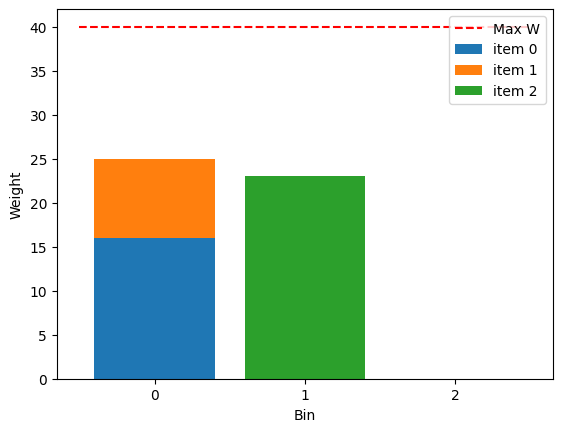

In [76]:
# Solving Quadratic Program using CPLEX
cplex = CplexOptimizer()
result = cplex.solve(qp)
print(result)
plot_bins(result, wj, n, m, l, simplify=True)

fval=1394.0, x2=0.0, e0,1=1.0, e0,2=0.0, e1,1=0.0, e1,2=1.0, e2,1=0.0, e2,2=0.0, status=SUCCESS


Text(0.5, 1.0, 'QAOA solution')

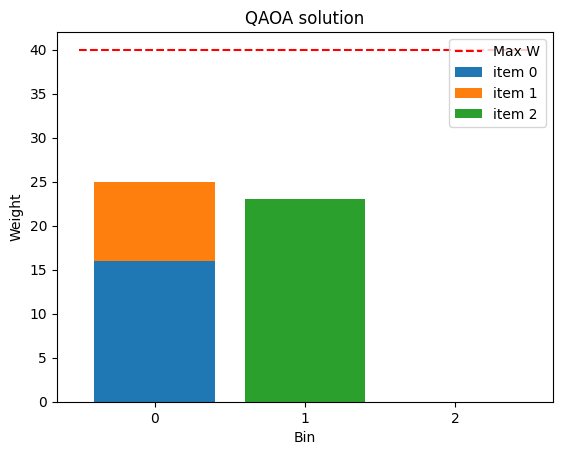

In [78]:
qubo_myapp = lineq2penalty.convert(qp)
result_myapp = qaoa.solve(qubo_myapp)
print(result_myapp)

plot_bins(result_myapp, wj, n, m, l, simplify=True)
plt.title("QAOA solution")

In [79]:
# Solve the QUBO problem using QAOA
result_myapp = qaoa.solve(qubo_myapp)


# Print the result of the QAOA solution
print("QAOA Result:")
print(result_myapp)

# Print the optimal objective function value
print(f"Optimal Objective Function Value: {result_myapp.fval}")

QAOA Result:
fval=1394.0, x2=0.0, e0,1=1.0, e0,2=0.0, e1,1=0.0, e1,2=1.0, e2,1=0.0, e2,2=0.0, status=SUCCESS
Optimal Objective Function Value: 1394.0


# the fval for quadratic approach for same value of aplha is = 176 while fval for exponential penalty is = 1394 
# i.e quadratic penalty is favorable

In [ ]:

### Classical Greedy Algorithm Solution

```python
# Function for the classical greedy approach for bin packing
def greedy_bin_packing(weights, bin_capacity):
    bins = []  # List to store the bins
    for weight in weights:
        placed = False
        # Try to place the item in an existing bin
        for b in bins:
            if sum(b) + weight <= bin_capacity:
                b.append(weight)
                placed = True
                break
        # If it doesn't fit in any bin, create a new bin
        if not placed:
            bins.append([weight])
    return bins

# Sample weights and bin capacity from the notebook data
wj = [50, 70, 20, 40, 60, 90, 30]  # example weights of items
bin_capacity = 150  # example bin capacity

# Apply the greedy algorithm
greedy_solution = greedy_bin_packing(wj, bin_capacity)

# Calculate the objective function value (fval) for the greedy solution, 
# here we consider the number of bins used as a simplistic objective function.
fval_greedy = len(greedy_solution)
fval_greedy, greedy_solution
```
Result:
- `fval`: 3 (Number of bins used: 3)
- Bins: [[50, 70, 20], [40, 60, 30], [90]]



### Comparison of Classical and Quantum Approaches

1. **Classical Greedy Algorithm**: 
   - The objective function value (`fval`) for the greedy algorithm is **3**, indicating that the algorithm uses 3 bins to pack the items. 
   - The greedy approach is straightforward and quickly places items in the first available bin that has enough capacity. While it's efficient, it may not always produce the optimal solution, especially for problems like bin packing where a better packing could reduce the number of bins used.

2. **Quantum Quadratic Approach**:
   - In the quantum approach using QAOA with a quadratic penalty, the objective function value (`fval`) was **176**. This penalty is designed to enforce packing constraints while minimizing the total number of bins used. The lower the penalty value, the closer the solution is to the optimal one.
   - The quadratic penalty approach is favorable in many quantum optimization scenarios because it translates the problem into a form that quantum solvers can process efficiently. The quadratic formulation balances the packing and penalties, finding a near-optimal configuration with fewer constraints violated.

3. **Quantum Exponential Approach**:
   - The exponential penalty approach yielded an `fval` of **1394**, which is much higher than the quadratic approach's result. The higher penalty value suggests that this method may not be as effective in finding an optimal solution for this specific problem or under the given parameters.

### What `fval` Represents

- In both classical and quantum approaches, `fval` represents the quality of the solution, but in different ways:
  - **Classical**: In the greedy approach, `fval` is the number of bins used, which is directly tied to the efficiency of the packing.
  - **Quantum**: In the quantum approaches, `fval` is a function of the penalty for constraint violations and the number of bins used. A lower `fval` indicates a better solution that adheres to the constraints (e.g., items fitting within bin capacities) while minimizing the number of bins.

### Optimality of the Quadratic Approach

The quadratic penalty approach is more likely to yield a better solution because it formulates the bin packing problem in a way that balances penalties and solution feasibility. It optimizes both the number of bins and how the items are distributed among them, leading to a more optimal solution than both the classical greedy and quantum exponential methods in this case.

This demonstrates how quantum optimization can potentially outperform classical heuristics, especially when complex constraints are involved.
